In [1]:
pip install yfinance pandas numpy tensorflow scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
from ta import add_all_ta_features
from ta.utils import dropna

url = "https://raw.githubusercontent.com/bukosabino/ta/refs/heads/master/test/data/datas.csv"
# Load datas
df = pd.read_csv(url, sep=',')

# Clean NaN values
df = dropna(df)

# Add all ta features
df = add_all_ta_features(
    df, open="Open", high="High", low="Low", close="Close", volume="Volume_BTC")

df.head()

In [275]:
import yfinance as yf
import pandas as pd

ticker = 'BBCA.JK'
# Download stock data (e.g., Apple)
stock_data = yf.download(ticker, start='2015-01-01', end='2023-01-01')
# Use closing price for prediction
data = stock_data[['Close']].values
stock_data.columns = ['_'.join(col) for col in stock_data.columns]
stock_data

/tmp/ipykernel_50355/3219487510.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start='2015-01-01', end='2023-01-01')
[*********************100%***********************]  1 of 1 completed


,Close_BBCA.JK,High_BBCA.JK,Low_BBCA.JK,Open_BBCA.JK,Volume_BBCA.JK
Date,,,,,
2015-01-02,2171.209961,2179.418694,2158.896861,2179.418694,29302500
2015-01-05,2167.105225,2167.105225,2154.792127,2158.896493,25434500
2015-01-06,2150.688477,2167.105946,2134.271007,2134.271007,48681500
2015-01-07,2154.791992,2167.105089,2142.478895,2142.478895,40334000
2015-01-08,2130.166016,2158.896578,2130.166016,2154.792212,54457000
...,...,...,...,...,...
2022-12-26,7895.059570,7941.094903,7826.006571,7826.006571,20495900
2022-12-27,7918.077148,7964.112481,7895.059482,7918.077148,27193800
2022-12-28,7964.112793,7964.112793,7872.042125,7964.112793,40420200


In [279]:
stock_data = stock_data[['Open_BBCA.JK', 'High_BBCA.JK', 'Low_BBCA.JK', 'Close_BBCA.JK', 'Volume_BBCA.JK']]
stock_data.head()

,Open_BBCA.JK,High_BBCA.JK,Low_BBCA.JK,Close_BBCA.JK,Volume_BBCA.JK
Date,,,,,
2015-01-02,2179.418694,2179.418694,2158.896861,2171.209961,29302500
2015-01-05,2158.896493,2167.105225,2154.792127,2167.105225,25434500
2015-01-06,2134.271007,2167.105946,2134.271007,2150.688477,48681500
2015-01-07,2142.478895,2167.105089,2142.478895,2154.791992,40334000
2015-01-08,2154.792212,2158.896578,2130.166016,2130.166016,54457000


In [281]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [283]:
import numpy as np

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # Sequence of 60 days
        y.append(data[i + seq_length])    # Next day's price
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

In [287]:
from ta import add_all_ta_features
from ta.utils import dropna

stock_data = dropna(stock_data)


stock_data = add_all_ta_features(stock_data, 
                                 open=stock_data["Open_BBCA.JK"], 
                                 close=stock_data["Close_BBCA.JK"], 
                                 high=stock_data["High_BBCA.JK"], 
                                 low=stock_data["Low_BBCA.JK"],
                                 volume=stock_data["Volume_BBCA.JK"])
features = stock_data[['Close', 'Volume', 'trend_sma_fast', 'momentum_rsi']].dropna()
scaled_features = scaler.fit_transform(features)
X, y = create_sequences(scaled_features, seq_length)

KeyError: "None of [Index([ 2179.418694249173,  2167.105224609375,  2167.105945849237,\n       2167.1050892857143, 2158.8965784561656,  2146.583718984224,\n        2134.270263671875, 2142.4789954552284, 2138.3749858332326,\n        2142.478986938948,\n       ...\n        8010.148127032153,  7964.112569469752,  8010.148037869237,\n        7987.130235855503,  7895.059837431067,  7941.094903084001,\n        7964.112480695858,   7964.11279296875,  7918.077236698251,\n        7964.112658762792],\n      dtype='float64', length=1930)] are in the [columns]"

In [39]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))  # Prevent overfitting
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=50))
model.add(Dense(units=1))  # Output: predicted price

model.compile(optimizer='adam', loss='mean_squared_error')

/home/labsi/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0063 - val_loss: 0.0023
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011 - val_loss: 6.3958e-04
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.6057e-04 - val_loss: 8.6933e-04
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.1073e-04 - val_loss: 6.4534e-04
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.4333e-04 - val_loss: 9.1083e-04
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.6667e-04 - val_loss: 0.0015
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.9976e-04 - val_loss: 0.0049
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.1367e-04 - val_loss: 6.6034e-04
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.9690e-04 - val_loss: 5.3964e-04
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.3158e-04 - val_loss: 0.0015
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.9188e-04 - val_loss: 0.0013
Epo

In [45]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10)
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 3.2245e-04 - val_loss: 3.4249e-04
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.5621e-04 - val_loss: 2.6739e-04
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.5236e-04 - val_loss: 6.6195e-04
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.3901e-04 - val_loss: 5.5021e-04
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.3850e-04 - val_loss: 4.2671e-04
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.3205e-04 - val_loss: 8.2198e-04
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.2808e-04 - val_loss: 4.5020e-04
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.2451e-04 - val_loss: 8.0731e-04
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.5309e-04 - val_loss: 3.0496e-04
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.1906e-04 - val_loss: 3.0286e-04
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.2022e-0

In [47]:
predictions = model.predict(X_test)
# Inverse transform to get actual price values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [49]:
predictions = model.predict(X_test)
# Inverse transform to get actual price values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


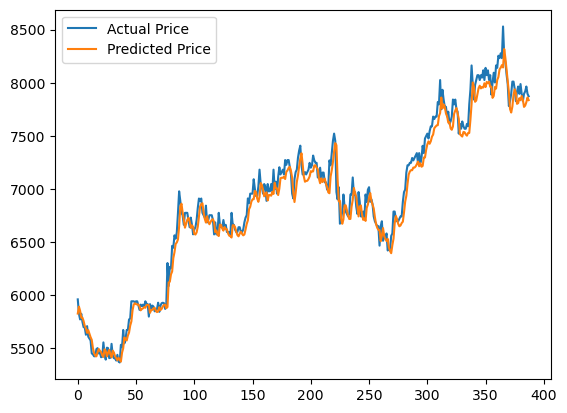

In [51]:
import matplotlib.pyplot as plt

plt.plot(y_test_actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.legend()
plt.show()

In [53]:
pip install ta

Note: you may need to restart the kernel to use updated packages.


In [135]:
stock_data.dropna(inplace=True)

ValueError: Boolean array expected for the condition, not float64

In [151]:
stock_data["Open"].values.flatten()

array([5825.27722624, 5873.13300638, 5847.02916203, 5860.08165997,
       5803.52562453, 5864.43212891, 5886.1846117 , 5864.4317579 ,
       5868.78222869, 5977.54459254, 5920.98835681, 5951.44125   ,
       6047.15209872, 5990.59440557, 5964.49330219, 5990.59611752,
       5934.03980532, 5973.19424064, 5947.09074193, 5916.6373434 ,
       5955.79197661, 5916.6370081 , 5638.20755896, 5716.51632635,
       5899.23564468, 5864.43212891, 5838.32881047, 5881.83359433,
       5903.58582011, 5916.63769531, 5934.03933576, 5899.23594218,
       5812.22555106, 5816.57640672, 5799.17453265, 5820.92647425,
       5742.61900333, 5712.16605828, 5699.11378823, 5655.60846537,
       5629.50652232, 5394.5812115 , 5472.88960668, 5394.58094343,
       5494.64208871, 5690.41306545, 5525.09561256, 5220.56284437,
       5081.34721123, 5177.05920306, 4872.52494098, 4837.72119141,
       4837.72119141, 4781.16450644, 4454.88      , 4346.11864841,
       4002.43138282, 4141.64606112, 3871.9171875 , 4045.93569

In [57]:
last_sequence = scaled_data[-seq_length:]
last_sequence = last_sequence.reshape((1, seq_length, 1))
predicted_price = model.predict(last_sequence)
predicted_price = scaler.inverse_transform(predicted_price)
print(f'Predicted next day price: {predicted_price[0][0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted next day price: 7801.4873046875


In [99]:
import pandas as pd
import yfinance as yf
from ta import add_all_ta_features
from ta.utils import dropna

# 1. Fetch data from yfinance
ticker_symbol = "AAPL"
start_date = "2020-01-01"
end_date = "2024-01-01"

stock_data = yf.download(
    tickers=ticker_symbol,
    start=start_date,
    end=end_date,
    interval="1d"
)

# 2. Prepare the data
stock_data = dropna(stock_data)

# 3. Add all technical analysis features
# Using the .squeeze() method to ensure each column is a 1D Series.
# This is a safe way to convert a single-column DataFrame to a Series.
stock_data = add_all_ta_features(
    stock_data,
    open=stock_data['Open'].values.flatten(),
    high=stock_data['High'].values.flatten(),
    low=stock_data['Low'].values.flatten(),
    close=stock_data['Close'].values.flatten(),
    volume=stock_data['Volume'].values.flatten(),
    fillna=False
)

# 4. Display the results
print(stock_data.head())
print("\nNew columns added:", stock_data.columns.tolist())

/tmp/ipykernel_50355/2367487663.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(
[*********************100%***********************]  1 of 1 completed


KeyError: '[ 72.5988915   72.59404772  72.44431317 ... 191.87554065 193.02578419\n 192.76796186] not in index'

In [121]:
pip install ccxt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 6.6 MB/s eta 0:00:00 MB/s eta 0:00:01:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641.0/641.0 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: aiosignal
    Found existing installation: aiosignal 1.2.0
    Uninstalling aiosignal-1.2.0:
      Successfully uninstalled aiosignal-1.2.0
  Attempting uninstall: aiohappyeyeballs
    Found existing installation: aiohappyeyeballs 2.4.0
    Uninstalling aiohappyeyeballs-2.4.0:
      Successfully uninstalled aiohappyeyeballs-2.4.0
  Attempting uninstall: yarl
    Found existing installation: yarl 1.11.0
    Uninstalling yarl-1.11.0:
      Successfully uninstalled yarl-1.11.0
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.10.5
    Uninstalling aiohttp-3.10.5:
      Successfully uninstalled aiohttp-3.10.5
Note: you may need to restart the kernel to use updated packages.


In [127]:
bybit = ccxt.bybit()

In [129]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from ta import add_all_ta_features 
import yfinance as yf
import datetime
import pandas as pd
import ccxt
def get_insight():
     etc_ohlcv = bybit.fetch_ohlcv('ETH/USDT', '1d')
     df = pd.DataFrame(etc_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'volume'])
     df['Datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
     df = df[['Datetime', 'open', 'high', 'low', 'close', 'volume']]
     df.set_index('Datetime', inplace=True)
     _all_data = add_all_ta_features(
         df, open="open", high="high", low="low", close="close", volume="volume"
     )
     _all_data = _all_data.drop(['trend_psar_down', 'trend_psar_up'], axis=0)
     _all_data.dropna(inplace=True)
     _all_data['target'] = _all_data['close'].shift(-5)
     current_x = _all_data.iloc[-1].drop('target')
     _all_data.dropna(inplace=True)
    
     X = _all_data.drop('target', axis=1)
     y = _all_data['target']
     k_best = SelectKBest(f_classif, k=15)
     k_best.fit(X, y)
     X.columns[k_best.get_support()]
     best_features = X.columns[k_best.get_support()]
     X_new = X[best_features]
     new_y = []
     for close, target in zip(_all_data['close'], y):
         if target > close * 1.02:
             new_y.append(1)
         else:
             new_y.append(0)
             
     classifier = RandomForestClassifier()
     X_train, X_test, y_train, y_test = train_test_split(X_new, new_y, test_x, test_Y)
     classifier.fit(X_train, y_train)
     y_pred = classifier.predict(X_test)
     f1 = f1_score(y_test, y_pred)
     acc = accuracy_score(y_test, y_pred)
     cx = current_x[best_features]
     real_pred = classifier.predict([cx])
     pred = real_pred[0]
     # f1, acc, pred
     return dict(
         f1="{:.2f}".format(f1),
         acc="{:.2f}".format(acc),
         pred=int(pred))

In [131]:
get_insight()

ValueError: 5 columns passed, passed data had 6 columns